### LSA Model

Load Dataset

In [1]:
import pandas as pd

# load dataset
dataset_path = 'cnn_news_articles_final_downsampled_cleaned.csv'
df = pd.read_csv(dataset_path)

Feature Extraction (BoW)

In [2]:
# use bow vectorizer
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer()
bow_doc_term_matrix = bow_vectorizer.fit_transform(df['text'])

In [3]:
bow_doc_term_matrix.shape

(9570, 26534)

LSA Model

In [4]:
from sklearn.decomposition import TruncatedSVD

# LSA model
n_topics = 10
lsa_model = TruncatedSVD(n_components=n_topics) # n_topics = 10 # n_components=n_topics
lsa_model.fit(bow_doc_term_matrix)

TruncatedSVD(n_components=10)

MLflow Server

In [5]:
import mlflow
from mlflow.tracking import MlflowClient

# convert model name to string
model_name = lsa_model.__class__.__name__
vectorizeer_name = bow_vectorizer.__class__.__name__   

# start MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("topic-modelling")

# initialize MLflow client
client = MlflowClient()

# experiment ID
experiment_id = client.get_experiment_by_name("topic-modelling").experiment_id

runs = client.search_runs(experiment_ids=[experiment_id])

# initial version to 0
max_version = 0

# find the max version for the current version model
for run in runs:
    run_name = run.data.tags.get('mlflow.runName')
    if run_name and run_name.startswith(model_name):        
        # extract version number from the run name
        try:
            version = int(run_name.split('_v')[-1])
        except ValueError:
            continue  # skip if version is not an integer

        # update max_version if this version is greater
        max_version = max(max_version, version)

# increase the version by adding 1
new_version = max_version + 1

# new run name
new_run_name = f"{model_name}_v{new_version}"
mlflow.start_run(run_name=new_run_name)

mlflow.log_param("model name", model_name)
mlflow.log_param("dataset_name", dataset_path)
mlflow.log_param("data size", df.shape)

(9570, 2)

Topic Words Score visualization

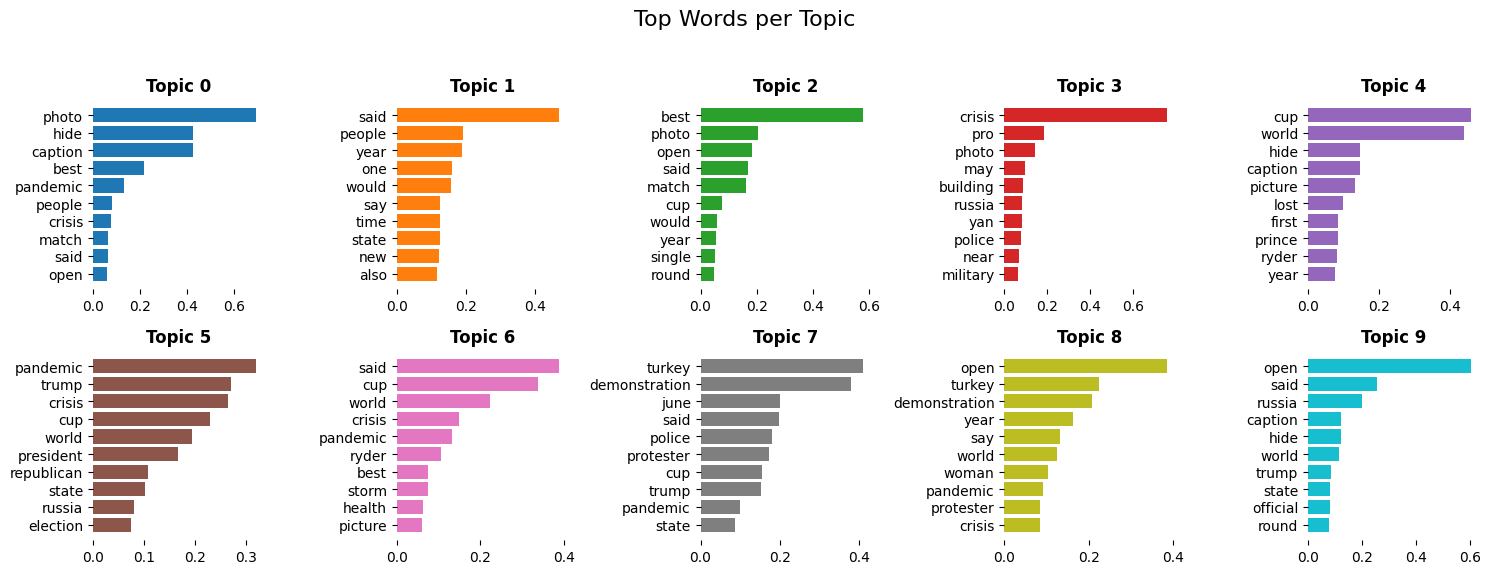

In [6]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = bow_vectorizer.get_feature_names_out() 

# colors for each topic
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=False, sharey=False)
axes = axes.flatten()

for i, (topic, color) in enumerate(zip(lsa_model.components_, colors)):
    top_words_idx = np.argsort(topic)[::-1][:10]  # descending order
    top_words = feature_names[top_words_idx]
    top_scores = topic[top_words_idx]

    ax = axes[i]
    ax.barh(top_words, top_scores, color=color)
    ax.set_title(f'Topic {i}', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=10)
    for spine in ax.spines.values():
        spine.set_visible(False)

fig.suptitle('Top Words per Topic', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Using Gensim to calculate the Coherence Scores

In [7]:
from gensim.corpora.dictionary import Dictionary

# create dic, corpus and tokenized
tokenized_docs = [doc.split() for doc in df['text']]
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

Evaluate by Coherence Scores

In [8]:
from gensim.models import CoherenceModel

# extract top words from LSA topics
topics = lsa_model.components_
top_words_per_topic = []

for topic in topics:
    top_words_idx = topic.argsort()[-10:]  # Get indices of the top words for this topic
    top_words = [feature_names[i] for i in top_words_idx]
    top_words_per_topic.append(top_words)

cv_coherence_model = CoherenceModel(topics=top_words_per_topic, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
cv_coherence = cv_coherence_model.get_coherence()

umass_coherence_model = CoherenceModel(topics=top_words_per_topic, corpus=corpus, dictionary=dictionary, coherence='u_mass')
umass_coherence = umass_coherence_model.get_coherence()

npmi_coherence_model = CoherenceModel(topics=top_words_per_topic, texts=tokenized_docs, dictionary=dictionary, coherence='c_npmi')
npmi_coherence = npmi_coherence_model.get_coherence()

print(f"C_V Coherence Score: {cv_coherence}")
print(f"U_Mass Coherence Score: {umass_coherence}")
print(f"NPMI Coherence Score: {npmi_coherence}")

mlflow.log_metric("c_v coherence", cv_coherence)
mlflow.log_metric("u_mass coherence", umass_coherence)
mlflow.log_metric("NPMI coherence", npmi_coherence)

C_V Coherence Score: 0.39854010879166235
U_Mass Coherence Score: -1.5943256819891571
NPMI Coherence Score: 0.04571718995076015


Save Model

In [9]:
# import joblib

# joblib.dump(lsa_model, 'lsa_model.pkl')
# joblib.dump(bow_vectorizer, 'lsa_bow_vectorizer.pkl')  

Plot Topics over time

In [10]:
import pandas as pd
import plotly.express as px

df = pd.read_csv('cnn_news_articles_final_cleaned.csv')

df['date published'] = pd.to_datetime(df['date published'])

bow_corpus = bow_vectorizer.transform(df['text'])

topic_distributions = lsa_model.transform(bow_corpus)

topics_df = pd.DataFrame(topic_distributions, columns=[f"Topic {i}" for i in range(lsa_model.n_components)])

df = pd.concat([df, topics_df], axis=1)

df_grouped = df.groupby([df['date published'].dt.to_period('M')])[['Topic ' + str(i) for i in range(lsa_model.n_components)]].mean().reset_index()

df_grouped['date published'] = df_grouped['date published'].dt.to_timestamp()

def get_top_words(model, vectorizer, n_top_words=5):
    words = vectorizer.get_feature_names_out()
    topic_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_word_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [words[i] for i in top_word_indices]
        topic_words[topic_idx] = " + ".join(top_words)
    return topic_words

top_words = get_top_words(lsa_model, bow_vectorizer)

legend_labels = [f"Topic {i}: {top_words[i]}" for i in range(lsa_model.n_components)]

fig = px.line(df_grouped, 
              x='date published', 
              y=[f'Topic {i}' for i in range(lsa_model.n_components)], 
              title='Topics Over Time (LSA)',
              labels={'value': 'Average Topic Proportion', 'date published': 'Time'},
              markers=False)

for i, trace in enumerate(fig.data):
    trace.name = legend_labels[i] 

#### Performance

C_V Coherence Score: 0.40

U_Mass Coherence Score: -1.59

NPMI Coherence Score: 0.046